# Framework de Detecção de Deriva para Machine Learning

Este notebook implementa um framework para detecção e adaptação a mudanças conceituais (concept drift) em fluxos de dados.

## Estrutura do Framework

1. **Inicialização**: Treina um modelo inicial e configura o detector de deriva
2. **Processamento de Fluxo**: Para cada exemplo no fluxo:
   - Faz a predição com o modelo atual
   - Avalia o erro e atualiza o detector
   - Baseado no estado do detector (NORMAL, ALERTA, MUDANÇA):
     - Normal: Apenas coleta dados
     - Alerta: Adaptação incremental do modelo
     - Mudança: Reavaliação completa (usa pool de modelos ou treina um novo)

In [17]:
%pip install tqdm ipywidgets --upgrade


[notice] A new release of pip is available: 24.0 -> 25.0.1
[notice] To update, run: pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


In [18]:
# Importação de bibliotecas necessárias
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import SGDClassifier
from sklearn.metrics import accuracy_score, f1_score
import copy
from tqdm.notebook import tqdm

## 1. Implementação do Detector de Deriva

Vamos implementar o ECDD (Error-based Concept Drift Detector) como exemplo

In [19]:
class ECDD:
    """
    Error-based Concept Drift Detector - baseado no algoritmo ECDD
    """
    def __init__(self, lambda_=0.05, warning_threshold=2.0, drift_threshold=3.0):
        self.lambda_ = lambda_  # Fator de decaimento exponencial
        self.warning_threshold = warning_threshold
        self.drift_threshold = drift_threshold

        # Inicialização de estatísticas
        self.mean = 0.0
        self.s_squared = 0.0
        self.instance_count = 0
        self.sum = 0.0
        self.squared_sum = 0.0

        # Estado atual
        self._current_state = "NORMAL"

    def update(self, error):
        """Atualiza o detector com um novo valor de erro"""
        self.instance_count += 1

        # Atualizações EWMA (Exponentially Weighted Moving Average)
        if self.instance_count == 1:
            self.mean = error
            self.s_squared = 0.0
        else:
            old_mean = self.mean
            self.mean = self.lambda_ * error + (1 - self.lambda_) * old_mean
            self.s_squared = self.lambda_ * ((error - old_mean) ** 2) + (1 - self.lambda_) * self.s_squared

        # Cálculo do desvio padronizado
        if self.instance_count < 30 or self.s_squared == 0:
            self._current_state = "NORMAL"
            return

        # Valor estatístico para detectar desvios
        deviation = abs(error - self.mean) / (self.s_squared ** 0.5)

        # Atualização do estado
        if deviation > self.drift_threshold:
            self._current_state = "MUDANÇA"
            # Reiniciar o detector após detectar mudança
            self.mean = error
            self.s_squared = 0.0
        elif deviation > self.warning_threshold:
            self._current_state = "ALERTA"
        else:
            self._current_state = "NORMAL"

    def current_state(self):
        """Retorna o estado atual do detector"""
        return self._current_state

## 2. Wrapper para Modelos

Classe para encapsular modelos de machine learning com funções para treinamento incremental e avaliação

In [20]:
class ModelWrapper:
    def __init__(self, model, incremental=False, name="Model"):
        self.model = model
        self.name = name
        self.supports_incremental = incremental
        self.predictions = []
        self.performance_history = []

    def train(self, X, y):
        """Treina o modelo com um conjunto de dados completo"""
        try:
            # Garantir que temos pelo menos duas classes para classificadores
            unique_classes = np.unique(y)
            print(f"Classes nos dados de treinamento: {unique_classes}, shape X: {X.shape}, shape y: {y.shape}")

            if len(unique_classes) < 2:
                print(f"AVISO: Tentativa de treinar com apenas {len(unique_classes)} classes. Necessário pelo menos 2.")
                return False

            print(f"Treinando modelo {type(self.model).__name__} com {len(y)} exemplos...")
            self.model.fit(X, y)

            # Verificar se o modelo foi realmente treinado
            if hasattr(self.model, 'coef_'):
                print(f"✓ Modelo treinado com sucesso. Shape dos coeficientes: {self.model.coef_.shape}")
                return True
            else:
                print("⚠️ O modelo não parece estar treinado corretamente (sem atributo coef_).")
                return False
        except Exception as e:
            print(f"ERRO durante fit: {e}")
            import traceback
            traceback.print_exc()  # Imprime o stack trace completo para debug
            return False

    def predict(self, X):
        """Faz predição com o modelo"""
        return self.model.predict(X)

    def train_incremental(self, x, y):
        """Treina o modelo incrementalmente com um novo ponto de dados."""
        if not self.supports_incremental:
            print("Aviso: Modelo não suporta treinamento incremental.")
            return

        # Garante que x seja 2D e y seja 1D
        if x.ndim == 1:
            x = x.reshape(1, -1)
        if isinstance(y, (int, float, np.number)): # Verifica se y é escalar
             y = np.array([y]) # Converte para array 1D
        elif isinstance(y, list): # Se for lista, converte
             y = np.array(y)

        # Chama partial_fit SEM o argumento classes
        # O modelo já deve conhecer as classes do treinamento inicial (fit)
        try:
            # A maioria dos modelos que suportam partial_fit esperam as classes do fit inicial
            self.model.partial_fit(x, y)
        except AttributeError:
             # Fallback caso o modelo não tenha partial_fit (embora supports_incremental deva checar)
             print(f"Aviso: Modelo {type(self.model).__name__} não parece ter partial_fit.")
        except Exception as e:
             print(f"Erro durante partial_fit: {e}")
             # Pode ser útil inspecionar x e y aqui se o erro persistir
             # print("x shape:", x.shape)
             # print("y shape:", y.shape)
             # print("y content:", y)
             raise e # Re-levanta a exceção para não continuar com erro

    def evaluate(self, X, y):
        """Avalia o desempenho do modelo"""
        y_pred = self.predict(X)
        accuracy = accuracy_score(y, y_pred)
        f1 = f1_score(y, y_pred, average='weighted')
        return {"accuracy": accuracy, "f1": f1}

## 3. Funções Auxiliares para o Framework

In [21]:
def calculate_error(y_true, y_pred):
    """Calcula o erro entre a predição e o valor real"""
    return 1.0 if y_pred != y_true else 0.0

def add_to_window(window, item, max_size=200):
    """Adiciona um item à janela e mantém seu tamanho limitado"""
    window.append(item)
    if len(window) > max_size:
        window.pop(0)
    return window

def select_best_model(model_pool, recent_data_window):
    """Seleciona o melhor modelo do pool com base no desempenho na janela recente"""
    if not recent_data_window:
        return model_pool[-1]  # Retorna o modelo mais recente se não houver dados

    # Prepara os dados para avaliação
    X_window = np.array([item[0] for item in recent_data_window])
    y_window = np.array([item[1] for item in recent_data_window])

    best_model = None
    best_performance = -1

    # Avalia cada modelo
    for model in model_pool:
        performance = model.evaluate(X_window, y_window)
        if performance['accuracy'] > best_performance:
            best_performance = performance['accuracy']
            best_model = model

    return best_model, best_performance

def get_batch_from_window(window):
    """Extrai features e labels da janela de dados"""
    if not window:
        return np.array([]), np.array([])

    X = np.array([item[0] for item in window])
    y = np.array([item[1] for item in window])
    return X, y

## 4. Carregamento de Dados Sintéticos para Simulação

Vamos criar dados sintéticos com mudanças de conceito para testar o framework

Dados gerados: (10000, 10) amostras com 10 características
Pontos de deriva em: [2500, 5000, 7500]


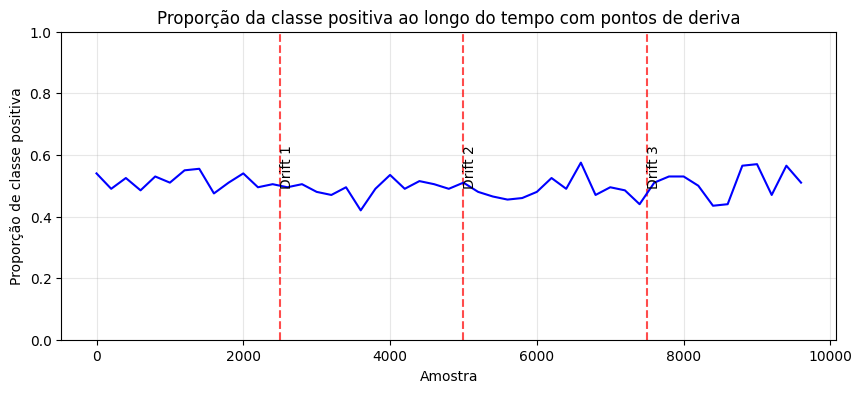

In [22]:
def generate_synthetic_data(n_samples=10000, n_features=10, n_drifts=3):
    """Gera dados sintéticos com concept drift"""
    X = np.random.randn(n_samples, n_features)
    y = np.zeros(n_samples)

    # Definir os pontos de mudança
    drift_points = [int(i * n_samples / (n_drifts + 1)) for i in range(1, n_drifts + 1)]

    # Função para criar regras diferentes para cada segmento
    def rule_1(x):
        return 1 if x[0] + x[1] > 0 else 0

    def rule_2(x):
        return 1 if x[2] - x[3] > 0 else 0

    def rule_3(x):
        return 1 if x[0] * x[4] > 0 else 0

    def rule_4(x):
        return 1 if np.sum(x[:5]) > 0 else 0

    rules = [rule_1, rule_2, rule_3, rule_4]

    # Aplicar regras diferentes em cada segmento
    current_rule = 0
    start_idx = 0

    for drift_point in drift_points + [n_samples]:
        for i in range(start_idx, drift_point):
            y[i] = rules[current_rule](X[i])

            # Adicionar ruído (5%)
            if np.random.random() < 0.05:
                y[i] = 1 - y[i]

        start_idx = drift_point
        current_rule = (current_rule + 1) % len(rules)

    return X, y, drift_points

# Gera dados de exemplo
X, y, drift_points = generate_synthetic_data()

print(f"Dados gerados: {X.shape} amostras com {X.shape[1]} características")
print(f"Pontos de deriva em: {drift_points}")

# Visualização da distribuição das classes
plt.figure(figsize=(10, 4))
for i, dp in enumerate(drift_points):
    plt.axvline(x=dp, color='r', linestyle='--', alpha=0.7)
    plt.text(dp, 0.5, f"Drift {i+1}", rotation=90)

# Plotar a proporção de classes em janelas
window_size = 200
positions = range(0, len(y) - window_size, window_size)
proportions = [np.mean(y[i:i+window_size]) for i in positions]

plt.plot(positions, proportions, 'b-')
plt.title('Proporção da classe positiva ao longo do tempo com pontos de deriva')
plt.xlabel('Amostra')
plt.ylabel('Proporção de classe positiva')
plt.ylim(0, 1)
plt.grid(True, alpha=0.3)
plt.show()

## 5. Implementação do Framework de Detecção de Deriva

In [23]:
def run_drift_detection_framework(X, y, initial_train_size=200, window_size=50, min_performance=0.6):
    """Executa o framework de detecção de deriva em um conjunto de dados"""
    # Dividir os dados em treinamento inicial e stream
    X_initial, y_initial = X[:initial_train_size], y[:initial_train_size]
    X_stream, y_stream = X[initial_train_size:], y[initial_train_size:]

    # Verificar se há classes suficientes nos dados iniciais
   # No início da função run_drift_detection_framework:

    # Verificar se há classes suficientes nos dados iniciais
    unique_classes = np.unique(y_initial)
    print(f"Classes nos dados iniciais: {unique_classes}")
    if len(unique_classes) < 2:
        raise ValueError(f"Os dados iniciais precisam ter pelo menos duas classes. Classes encontradas: {unique_classes}")

    # Tentar garantir que temos amostras balanceadas das classes
    min_samples_per_class = 10  # Definir número mínimo de amostras por classe
    class_counts = {c: np.sum(y_initial == c) for c in unique_classes}
    print(f"Contagem de amostras por classe nos dados iniciais: {class_counts}")

    # Se alguma classe tiver menos amostras que o mínimo, avisar
    for c, count in class_counts.items():
        if count < min_samples_per_class:
            print(f"AVISO: Classe {c} tem apenas {count} amostras. Recomendado pelo menos {min_samples_per_class}.")

    # Inicialização com parâmetros mais seguros para SGDClassifier
    print(f"Treinando modelo inicial com {len(y_initial)} exemplos...")
    # Modelo com suporte a treinamento incremental
    incremental_model = SGDClassifier(
        loss='log_loss',  # Função de perda
        max_iter=1000,    # Mais iterações para convergência
        tol=1e-3,         # Tolerância
        random_state=42,  # Semente para reprodutibilidade
        alpha=0.001,      # Regularização
        eta0=0.01,        # Taxa de aprendizado inicial
        learning_rate='constant'  # Taxa de aprendizado constante
    )
    current_model = ModelWrapper(incremental_model, incremental=True, name="SGDClassifier")

    # Garantir treinamento inicial correto
    print("Tentando treinar o modelo inicial...")
    train_success = current_model.train(X_initial, y_initial)

    if not train_success:
        print("Primeira tentativa de treinamento falhou. Tentando abordagem alternativa...")

        # Pode ser um problema de convergência ou dados, vamos tentar outra configuração
        alternative_model = SGDClassifier(
            loss='hinge',        # Função de perda SVM (pode ser mais estável)
            max_iter=2000,       # Aumentar iterações
            tol=1e-2,            # Relaxar tolerância
            random_state=42,
            alpha=0.01,          # Aumentar regularização
            class_weight='balanced',  # Pesos balanceados para classes
            learning_rate='adaptive'  # Taxa adaptativa
        )
        current_model = ModelWrapper(alternative_model, incremental=True, name="SGDClassifier_Alternative")
        train_success = current_model.train(X_initial, y_initial)

        if not train_success:
            print("Segunda tentativa também falhou. Tentando um modelo mais simples...")

            # Tentar um classificador mais simples
            from sklearn.linear_model import LogisticRegression
            simple_model = LogisticRegression(
                max_iter=2000,
                solver='lbfgs',
                random_state=42
            )
            current_model = ModelWrapper(simple_model, incremental=False, name="LogisticRegression")
            train_success = current_model.train(X_initial, y_initial)

            if not train_success:
                raise RuntimeError("Todas as tentativas de treinar o modelo inicial falharam. Verifique os dados.")

    # Teste para verificar se o modelo está realmente treinado
    try:
        test_pred = current_model.predict(X_initial[0:1])
        print("✓ Modelo inicial treinado com sucesso!")
    except Exception as e:
        raise RuntimeError(f"Modelo inicial não foi treinado corretamente: {e}")

    # Pool de modelos
    model_pool = [copy.deepcopy(current_model)]

    # Inicialização do detector
    detector = ECDD(lambda_=0.05, warning_threshold=2.0, drift_threshold=3.0)

    # Janela de dados recentes - inicialize com alguns dados do treinamento
    # Isso ajuda a ter dados de múltiplas classes disponíveis desde o início
    recent_data_window = [(X_initial[i], y_initial[i]) for i in range(max(0, len(X_initial)-10), len(X_initial))]

    # Métricas para acompanhamento
    accuracy_history = []
    error_history = []
    state_history = []
    drift_detections = []

    # Processamento do stream
    for i, (x_t, y_t) in tqdm(enumerate(zip(X_stream, y_stream)), total=len(X_stream)):
        # Garantir que x_t seja 2D para predição
        x_t_reshaped = x_t.reshape(1, -1)

        # Etapa 1: Predição
        try:
            y_pred = current_model.predict(x_t_reshaped)[0]
        except Exception as e:
            print(f"ERRO durante predição no ponto {initial_train_size + i}: {e}")
            # Usar um modelo do pool como fallback ou pular esta instância
            if len(model_pool) > 0:
                current_model = copy.deepcopy(model_pool[0])  # Use o primeiro modelo do pool como backup
                try:
                    y_pred = current_model.predict(x_t_reshaped)[0]
                except:
                    print("ERRO também no modelo de backup. Usando predição aleatória.")
                    y_pred = np.random.choice(unique_classes)  # Predição aleatória como último recurso
            else:
                y_pred = np.random.choice(unique_classes)  # Predição aleatória como último recurso

        # Etapa 2: Cálculo do erro
        error = calculate_error(y_t, y_pred)
        detector.update(error)

        # Etapa 3: Verificação do estado do detector
        state = detector._current_state  # Usar o atributo diretamente, evitando confusão com o método

        # Armazenar métricas
        error_history.append(error)
        state_history.append(state)

        if state == "NORMAL":
            # Apenas armazena os dados
            recent_data_window = add_to_window(recent_data_window, (x_t, y_t), window_size)

        elif state == "ALERTA":
            # Adapta o modelo incrementalmente
            if current_model.supports_incremental:
                current_model.train_incremental(x_t_reshaped, np.array([y_t]))
            recent_data_window = add_to_window(recent_data_window, (x_t, y_t), window_size)

        elif state == "MUDANÇA":
            # Registra o ponto de detecção de deriva
            drift_detections.append(initial_train_size + i)
            print(f"Drift detectado no ponto {initial_train_size + i}")

            # Adiciona uma cópia do modelo atual ao pool ANTES de possivelmente substituí-lo
            print(f"Adicionando modelo '{current_model.name}' ao pool (tamanho do pool: {len(model_pool)})")
            model_pool.append(copy.deepcopy(current_model))

            # Avalia modelos com base na janela recente
            X_recent, y_recent = get_batch_from_window(recent_data_window)

            if len(X_recent) > 10 and len(np.unique(y_recent)) > 1:  # Se tivermos dados suficientes e múltiplas classes
                best_model, best_performance = select_best_model(model_pool, recent_data_window)

                if best_performance >= min_performance:
                    # Não substituímos pelo mesmo modelo, apenas por outro do pool
                    if best_model.name != current_model.name:
                        current_model = copy.deepcopy(best_model)
                        print(f"Usando modelo do pool '{best_model.name}' com desempenho: {best_performance:.4f}")
                    else:
                        print(f"Mantendo modelo atual '{current_model.name}' (melhor do pool)")
                else:
                    # Treina um novo modelo com os dados recentes
                    print("Treinando novo modelo...")
                    new_model = SGDClassifier(loss='log_loss', random_state=42)
                    # Importante: dê um nome único ao novo modelo
                    new_model_name = f"New_SGD_{len(model_pool) + 1}"
                    current_model = ModelWrapper(new_model, incremental=True, name=new_model_name)
                    train_success = current_model.train(X_recent, y_recent)

                    # Se o treinamento for bem-sucedido, não precisamos adicionar aqui
                    # porque adicionaremos na próxima detecção de deriva
                    print(f"Novo modelo '{new_model_name}' treinado e definido como atual")
            else:
                # Se não tivermos dados suficientes, usamos o melhor modelo do pool
                print("Dados insuficientes ou falta de diversidade de classes. Usando melhor modelo do pool.")
                if len(model_pool) > 1:  # Garantir que haja mais de um modelo no pool
                    # Tenta encontrar um modelo diferente do atual
                    alternative_models = [m for m in model_pool if m.name != current_model.name]
                    if alternative_models:
                        best_model = alternative_models[0]  # Escolhe um modelo alternativo como padrão

                        # Tenta encontrar o melhor modelo alternativo
                        for model in alternative_models:
                            try:
                                if len(recent_data_window) > 5:
                                    X_recent, y_recent = get_batch_from_window(recent_data_window)
                                    current_score = current_model.evaluate(X_recent, y_recent)['accuracy']
                                    model_score = model.evaluate(X_recent, y_recent)['accuracy']
                                    if model_score > current_score:
                                        best_model = model
                                        break
                            except:
                                continue

                        # Muda para o modelo alternativo
                        if best_model.name != current_model.name:
                            current_model = copy.deepcopy(best_model)
                            print(f"Usando modelo alternativo do pool: '{current_model.name}'")
                        else:
                            print(f"Mantendo modelo atual '{current_model.name}' (melhor alternativa)")
                    else:
                        print(f"Não há modelos alternativos no pool. Mantendo '{current_model.name}'")
                else:
                    print(f"Apenas um modelo no pool. Mantendo '{current_model.name}'")

            # Limpa a janela para novos dados, começando com o exemplo atual
            recent_data_window = [(x_t, y_t)]

        # Calcular a acurácia da janela
        if i % 10 == 0 and len(recent_data_window) > 1:
            X_window, y_window = get_batch_from_window(recent_data_window)
            if len(X_window) > 0:
                try:
                    window_performance = current_model.evaluate(X_window, y_window)
                    accuracy_history.append(window_performance.get('accuracy', 0))
                except Exception as e:
                    print(f"Erro ao calcular acurácia: {e}")
                    accuracy_history.append(0)  # Assumimos acurácia zero em caso de erro
            else:
                accuracy_history.append(0)

    # Resultados finais
    results = {
        "model_pool": model_pool,
        "current_model": current_model,
        "accuracy_history": accuracy_history,
        "error_history": error_history,
        "state_history": state_history,
        "drift_detections": drift_detections
    }

    return results

## 6. Executar o Framework e Visualizar Resultados

Classes nos dados iniciais: [0. 1.]
Contagem de amostras por classe nos dados iniciais: {0.0: 92, 1.0: 108}
Treinando modelo inicial com 200 exemplos...
Tentando treinar o modelo inicial...
Classes nos dados de treinamento: [0. 1.], shape X: (200, 10), shape y: (200,)
Treinando modelo SGDClassifier com 200 exemplos...
✓ Modelo treinado com sucesso. Shape dos coeficientes: (1, 10)
✓ Modelo inicial treinado com sucesso!


  0%|          | 0/9800 [00:00<?, ?it/s]

Drift detectado no ponto 366
Adicionando modelo 'SGDClassifier' ao pool (tamanho do pool: 1)
Mantendo modelo atual 'SGDClassifier' (melhor do pool)
Drift detectado no ponto 367
Adicionando modelo 'SGDClassifier' ao pool (tamanho do pool: 2)
Dados insuficientes ou falta de diversidade de classes. Usando melhor modelo do pool.
Não há modelos alternativos no pool. Mantendo 'SGDClassifier'
Drift detectado no ponto 372
Adicionando modelo 'SGDClassifier' ao pool (tamanho do pool: 3)
Dados insuficientes ou falta de diversidade de classes. Usando melhor modelo do pool.
Não há modelos alternativos no pool. Mantendo 'SGDClassifier'
Drift detectado no ponto 373
Adicionando modelo 'SGDClassifier' ao pool (tamanho do pool: 4)
Dados insuficientes ou falta de diversidade de classes. Usando melhor modelo do pool.
Não há modelos alternativos no pool. Mantendo 'SGDClassifier'
Drift detectado no ponto 438
Adicionando modelo 'SGDClassifier' ao pool (tamanho do pool: 5)
Mantendo modelo atual 'SGDClassifier

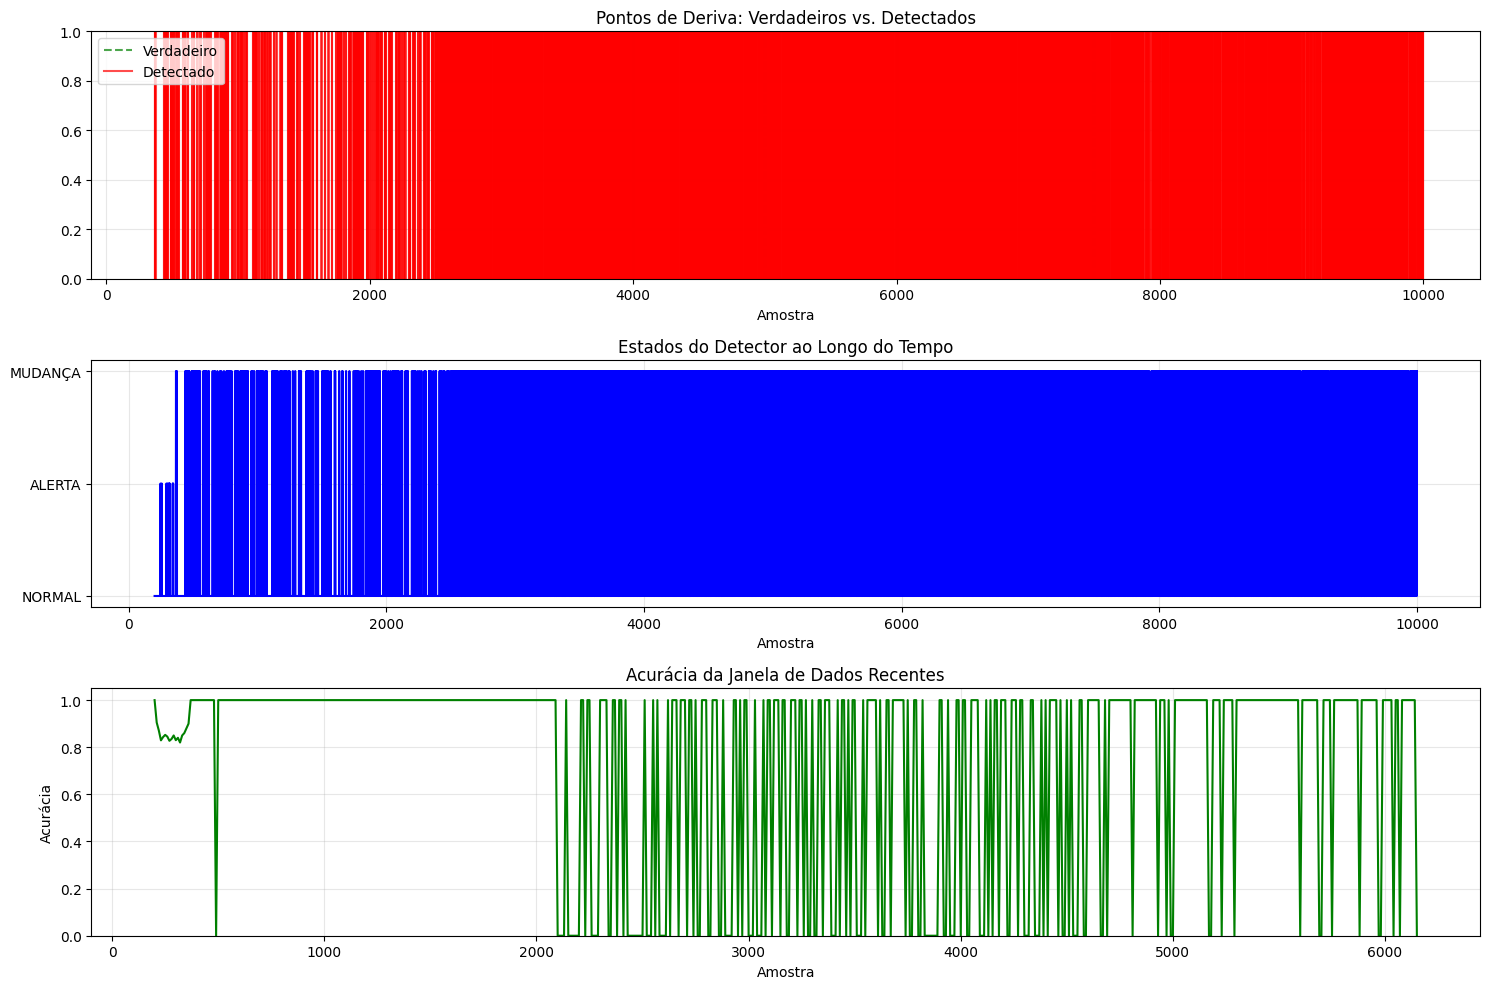

Número de modelos no pool: 3954
Pontos de deriva verdadeiros: [2500, 5000, 7500]
Pontos de deriva detectados: [366, 367, 372, 373, 438, 439, 447, 448, 450, 451, 460, 461, 463, 464, 467, 468, 487, 488, 493, 494, 496, 497, 499, 500, 509, 510, 516, 517, 529, 531, 536, 537, 540, 541, 552, 553, 578, 579, 580, 581, 587, 588, 594, 595, 597, 599, 615, 616, 621, 622, 650, 651, 664, 665, 667, 668, 687, 688, 707, 708, 718, 719, 738, 739, 758, 759, 763, 764, 769, 770, 777, 778, 780, 782, 785, 786, 797, 798, 824, 825, 834, 836, 838, 839, 840, 841, 848, 849, 866, 867, 871, 872, 881, 882, 889, 890, 891, 892, 893, 894, 901, 903, 905, 906, 907, 908, 920, 921, 923, 924, 951, 952, 960, 961, 973, 974, 995, 996, 998, 999, 1009, 1010, 1022, 1023, 1025, 1026, 1031, 1032, 1043, 1044, 1060, 1061, 1070, 1071, 1114, 1116, 1118, 1119, 1132, 1133, 1136, 1137, 1144, 1145, 1155, 1156, 1176, 1178, 1181, 1182, 1194, 1195, 1207, 1208, 1214, 1216, 1226, 1227, 1241, 1243, 1245, 1247, 1273, 1274, 1291, 1292, 1321, 1323, 1

In [24]:
# Executar o framework nos dados sintéticos
results = run_drift_detection_framework(X, y, initial_train_size=200, window_size=100)

# Visualizar os resultados
plt.figure(figsize=(15, 10))

# Subplot 1: Visualização dos pontos de deriva verdadeiros vs. detectados
plt.subplot(3, 1, 1)
plt.title('Pontos de Deriva: Verdadeiros vs. Detectados')
for dp in drift_points:
    plt.axvline(x=dp, color='g', linestyle='--', alpha=0.7, label='Verdadeiro' if dp == drift_points[0] else '')

for dd in results['drift_detections']:
    plt.axvline(x=dd, color='r', linestyle='-', alpha=0.7, label='Detectado' if dd == results['drift_detections'][0] else '')

plt.xlabel('Amostra')
plt.legend()
plt.grid(True, alpha=0.3)

# Subplot 2: Estados do detector
plt.subplot(3, 1, 2)
plt.title('Estados do Detector ao Longo do Tempo')
states = {'NORMAL': 0, 'ALERTA': 1, 'MUDANÇA': 2}
state_values = [states[s] for s in results['state_history']]
plt.plot(range(200, 200 + len(state_values)), state_values, 'b-')
plt.yticks([0, 1, 2], ['NORMAL', 'ALERTA', 'MUDANÇA'])
plt.xlabel('Amostra')
plt.grid(True, alpha=0.3)

# Subplot 3: Acurácia ao longo do tempo
plt.subplot(3, 1, 3)
plt.title('Acurácia da Janela de Dados Recentes')
# Calculamos as posições corretas no eixo x considerando o offset inicial e a periodicidade
x_positions = [200 + i*10 for i in range(len(results['accuracy_history']))]
plt.plot(x_positions, results['accuracy_history'], 'g-')
plt.ylim(0, 1.05)
plt.xlabel('Amostra')
plt.ylabel('Acurácia')
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Informações adicionais
print(f"Número de modelos no pool: {len(results['model_pool'])}")
print(f"Pontos de deriva verdadeiros: {drift_points}")
print(f"Pontos de deriva detectados: {results['drift_detections']}")